In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import models,layers 
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

C:\Users\tanze\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [2]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.25
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 16

CHANNELS = 3
EPOCHS = 200


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "shoes",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker']

In [6]:
len(dataset) # 10000 files/ Batch_size

625

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 256, 256, 3)
[1 4 2 4 2 4 1 4 0 1 3 2 1 2 0 3]


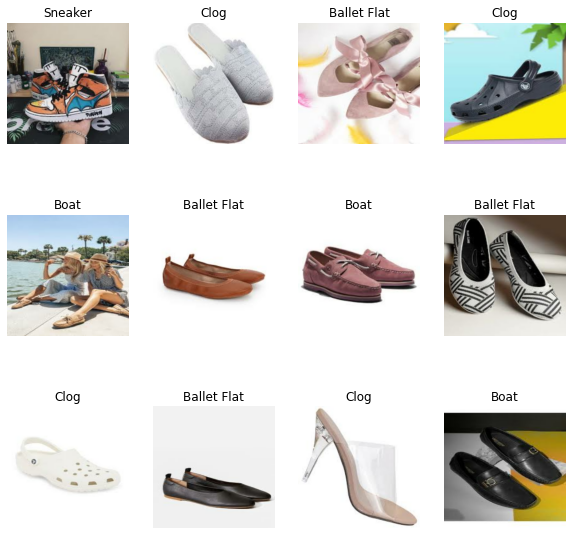

In [8]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])
    

In [9]:
len(dataset)

625

In [10]:
train_ds = dataset.take(int(0.8*313))
len(train_ds)

250

In [11]:
test_ds = dataset.skip(250)
len(test_ds)

375

In [12]:
val_ds = test_ds.take(31)
len(val_ds)

31

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

369

In [14]:
train_size=0.8
val_size = 0.1

def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [15]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [16]:
len(train_ds),len(val_ds),len(test_ds)

(500, 62, 63)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 5


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(16,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(16,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])


model.build(input_shape=input_shape)


In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (16, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (16, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (16, 254, 254, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 127, 127, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 125, 125, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 62, 62, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 60, 60, 64)         

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

In [23]:
# es_callback = EarlyStopping(
#             monitor = 'val_loss',
#             patience=20,
#             restore_best_weights = True)

tb_callback = TensorBoard(log_dir = "tb_callback_logs/", histogram_freq = 1)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[tb_callback]
)

Epoch 1/200
500/500 [==============================] - 231s 398ms/step - loss: 1.5411 - accuracy: 0.2937 - val_loss: 1.5078 - val_accuracy: 0.3407
Epoch 2/200
500/500 [==============================] - 59s 118ms/step - loss: 1.4786 - accuracy: 0.3436 - val_loss: 1.4934 - val_accuracy: 0.3407
Epoch 3/200
500/500 [==============================] - 73s 146ms/step - loss: 1.4540 - accuracy: 0.3517 - val_loss: 1.4770 - val_accuracy: 0.3458
Epoch 4/200
500/500 [==============================] - 56s 111ms/step - loss: 1.4340 - accuracy: 0.3664 - val_loss: 1.4445 - val_accuracy: 0.3750
Epoch 5/200
500/500 [==============================] - 60s 120ms/step - loss: 1.4225 - accuracy: 0.3689 - val_loss: 1.4176 - val_accuracy: 0.3921
Epoch 6/200
500/500 [==============================] - 43s 86ms/step - loss: 1.4085 - accuracy: 0.3758 - val_loss: 1.4097 - val_accuracy: 0.3690
Epoch 7/200
500/500 [==============================] - 41s 82ms/step - loss: 1.3922 - accuracy: 0.3895 - val_loss: 1.3826 - 

500/500 [==============================] - 33s 67ms/step - loss: 0.7595 - accuracy: 0.7136 - val_loss: 0.7941 - val_accuracy: 0.7117
Epoch 58/200
500/500 [==============================] - 31s 61ms/step - loss: 0.7523 - accuracy: 0.7175 - val_loss: 0.7864 - val_accuracy: 0.7097
Epoch 59/200
500/500 [==============================] - 30s 60ms/step - loss: 0.7327 - accuracy: 0.7254 - val_loss: 0.7749 - val_accuracy: 0.7077
Epoch 60/200
500/500 [==============================] - 52s 104ms/step - loss: 0.7318 - accuracy: 0.7271 - val_loss: 0.7588 - val_accuracy: 0.7147
Epoch 61/200
500/500 [==============================] - 32s 65ms/step - loss: 0.7239 - accuracy: 0.7333 - val_loss: 0.7583 - val_accuracy: 0.7117
Epoch 62/200
500/500 [==============================] - 31s 62ms/step - loss: 0.7278 - accuracy: 0.7265 - val_loss: 0.8285 - val_accuracy: 0.7137
Epoch 63/200
500/500 [==============================] - 31s 62ms/step - loss: 0.7356 - accuracy: 0.7271 - val_loss: 0.8066 - val_accurac

500/500 [==============================] - 72s 144ms/step - loss: 0.5177 - accuracy: 0.8190 - val_loss: 0.6210 - val_accuracy: 0.7974
Epoch 114/200
500/500 [==============================] - 30s 60ms/step - loss: 0.4954 - accuracy: 0.8198 - val_loss: 0.6620 - val_accuracy: 0.7923
Epoch 115/200
500/500 [==============================] - 29s 58ms/step - loss: 0.5066 - accuracy: 0.8173 - val_loss: 0.6040 - val_accuracy: 0.7994
Epoch 116/200
500/500 [==============================] - 29s 58ms/step - loss: 0.4873 - accuracy: 0.8244 - val_loss: 0.6313 - val_accuracy: 0.7923
Epoch 117/200
500/500 [==============================] - 30s 61ms/step - loss: 0.4884 - accuracy: 0.8196 - val_loss: 0.6713 - val_accuracy: 0.7873
Epoch 118/200
500/500 [==============================] - 30s 60ms/step - loss: 0.4920 - accuracy: 0.8209 - val_loss: 0.6458 - val_accuracy: 0.7923
Epoch 119/200
500/500 [==============================] - 33s 66ms/step - loss: 0.4781 - accuracy: 0.8290 - val_loss: 0.6166 - val_a

Epoch 169/200
500/500 [==============================] - 32s 64ms/step - loss: 0.3679 - accuracy: 0.8704 - val_loss: 0.6548 - val_accuracy: 0.8095
Epoch 170/200
500/500 [==============================] - 29s 59ms/step - loss: 0.3654 - accuracy: 0.8701 - val_loss: 0.5403 - val_accuracy: 0.8367
Epoch 171/200
500/500 [==============================] - 36s 72ms/step - loss: 0.3674 - accuracy: 0.8733 - val_loss: 0.5349 - val_accuracy: 0.8407
Epoch 172/200
500/500 [==============================] - 30s 59ms/step - loss: 0.3528 - accuracy: 0.8789 - val_loss: 0.4982 - val_accuracy: 0.8478
Epoch 173/200
500/500 [==============================] - 30s 60ms/step - loss: 0.3626 - accuracy: 0.8741 - val_loss: 0.5060 - val_accuracy: 0.8548
Epoch 174/200
500/500 [==============================] - 56s 112ms/step - loss: 0.3583 - accuracy: 0.8719 - val_loss: 0.5619 - val_accuracy: 0.8448
Epoch 175/200
500/500 [==============================] - 32s 63ms/step - loss: 0.3538 - accuracy: 0.8780 - val_loss: 

In [25]:
scores = model.evaluate(test_ds)

63/63 [==============================] - 68s 51ms/step - loss: 0.4767 - accuracy: 0.8581


In [26]:
scores

[0.476720929145813, 0.858134925365448]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 200, 'steps': 500}

In [29]:
history.history['accuracy']

[0.29374998807907104,
 0.343625009059906,
 0.351749986410141,
 0.36637499928474426,
 0.36887499690055847,
 0.37575000524520874,
 0.3894999921321869,
 0.39899998903274536,
 0.4165000021457672,
 0.4273749887943268,
 0.4463750123977661,
 0.47200000286102295,
 0.4908750057220459,
 0.49687498807907104,
 0.5023750066757202,
 0.515375018119812,
 0.530875027179718,
 0.5422499775886536,
 0.547124981880188,
 0.5544999837875366,
 0.562125027179718,
 0.5646250247955322,
 0.5807499885559082,
 0.581375002861023,
 0.5951250195503235,
 0.5914999842643738,
 0.6006249785423279,
 0.6018750071525574,
 0.6132500171661377,
 0.6182500123977661,
 0.6211249828338623,
 0.6302499771118164,
 0.6316249966621399,
 0.6353750228881836,
 0.6443750262260437,
 0.6423749923706055,
 0.656000018119812,
 0.6606249809265137,
 0.6613749861717224,
 0.6668750047683716,
 0.6708750128746033,
 0.6712499856948853,
 0.6777499914169312,
 0.684374988079071,
 0.6826249957084656,
 0.6909999847412109,
 0.6922500133514404,
 0.694000005722

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

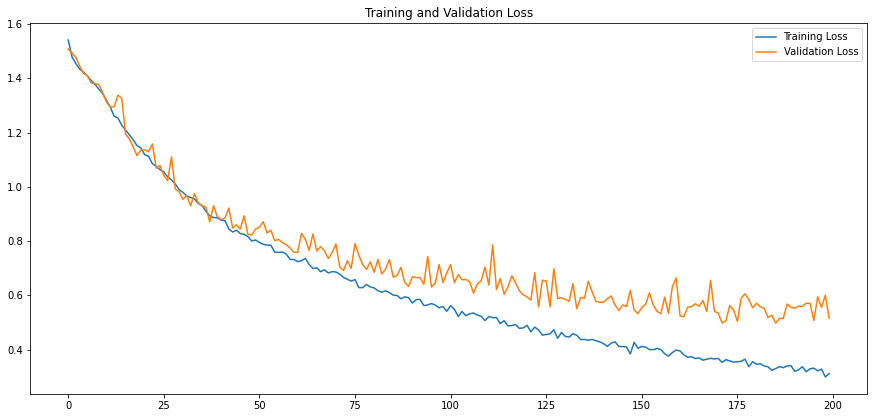

In [31]:
plt.figure(figsize=(15,15))
# plt.subplot(2,1,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


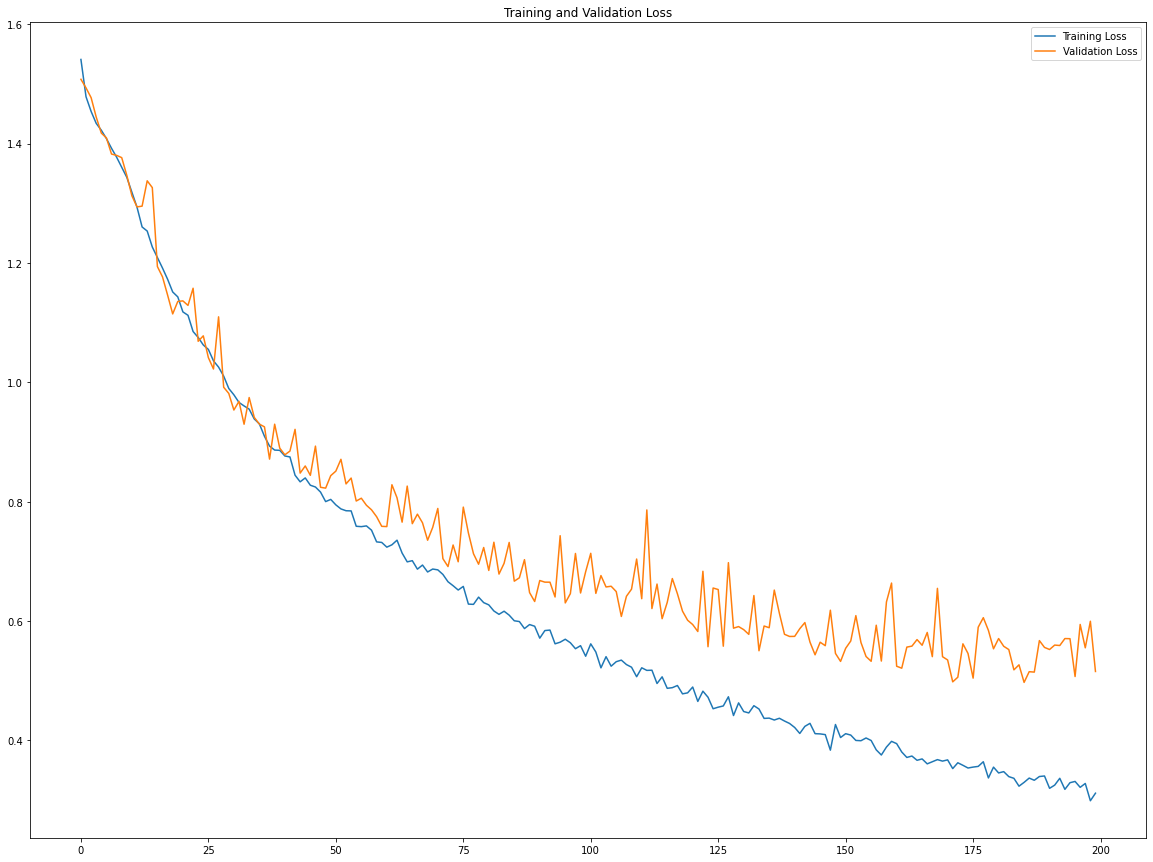

In [32]:
plt.figure(figsize=(20,15))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Boat
predicted label: Clog


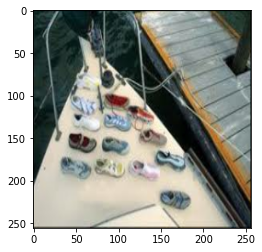

In [33]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

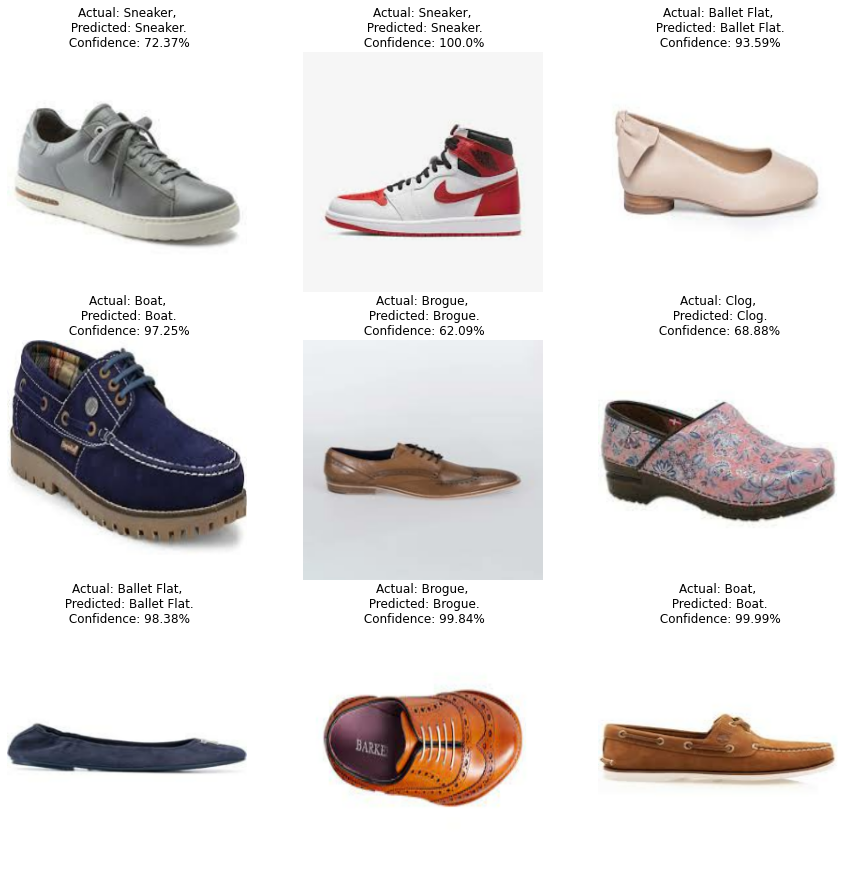

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")